# Shallow fully connected networks on CIFAR-10 using Keras

This notebook will guide you through the use of the `keras` package to train a multilayer perceptron for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998

We assume you are using TF 2. If you need to install some packages, use `pip install ...`, e.g. `pip install sklearn` for SciKit Learn.

## Loading the packages

In [2]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [55]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import utils
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix

%matplotlib inline

# fix random seed for reproducibility
np.random.seed(42)

## Loading the raw data
First load the `mnist` dataset and normalize it to be in the range [0, 1]

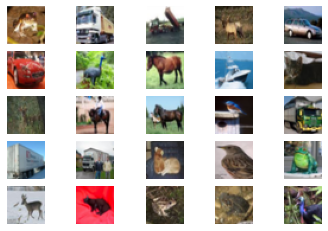

In [56]:
def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,5):
        for j in range(0,5):
            plt.subplot2grid((5,5),(i,j))
            plt.imshow(X[k], cmap='gray')
            k = k+1
            plt.axis('off')
    # show the plot
    plt.show()
    
# Load data & split data between train and test sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

show_imgs(X_train)

In [57]:
print(X_train.shape)
print(X_train.dtype)
print(y_train.shape)

(50000, 32, 32, 3)
uint8
(50000, 1)


In [59]:
# Normalize input
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [60]:
n_classes = 10
# Conversion to class vectors
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


# One-layer network and weight visualisation
## Define the network

In [61]:
E = 5                # number of epochs
B = 128              # batch size
D = X_train.shape[1:] # dimension of input sample - 784 for MNIST

regularizer = tf.keras.regularizers.L2(l2=0.01)

model = Sequential()
model.add(Flatten(input_shape=D))
model.add(Dense(n_classes, activation='softmax', kernel_regularizer=regularizer))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


## Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [62]:
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/5
391/391 [==============================] - 2s 4ms/step - loss: 2.1022 - accuracy: 0.3144 - val_loss: 2.0000 - val_accuracy: 0.3418
Epoch 2/5
391/391 [==============================] - 1s 3ms/step - loss: 1.9443 - accuracy: 0.3532 - val_loss: 1.8910 - val_accuracy: 0.3785
Epoch 3/5
391/391 [==============================] - 1s 3ms/step - loss: 1.9110 - accuracy: 0.3579 - val_loss: 1.9142 - val_accuracy: 0.3369
Epoch 4/5
391/391 [==============================] - 1s 2ms/step - loss: 1.8856 - accuracy: 0.3655 - val_loss: 1.9095 - val_accuracy: 0.3502
Epoch 5/5
391/391 [==============================] - 1s 2ms/step - loss: 1.8731 - accuracy: 0.3688 - val_loss: 1.8817 - val_accuracy: 0.3707


### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

(3072, 10)
(10,)


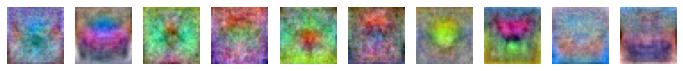

In [67]:
weights = model.get_weights()
for w in weights:
    print(w.shape)
w1 = weights[0]
f = plt.figure(figsize=(12, 12))
for i in range(10):
    ax = f.add_subplot(1, 10, 1+i)
    im = w1[:,i]
    im = im.reshape(32, 32, 3)
    # now put back the pixel values to 0-256 doing a min-max norm and multiplying by 256
    min = np.min(im)
    max = np.max(im)
    im = np.round((im - min)/(max - min) * 255).astype(int)
    ax.axis('off')
    ax.imshow(im)

# Two-layers network

## Define the network

In [78]:
E = 30
B = 128
D = X_train.shape[1:]

def create_model(n_neurons:int=128):
    model = Sequential()
    model.add(Flatten(input_shape=D))
    model.add(Dense(n_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
    
    return model

model = create_model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________


## Compile and train the network
In Keras, we call the methods `compile()` and `fit()`. For the compile phase, we need to specify the **loss** function which should be set in the case of multi-class classification to `categorical_crossentropy`. We also need to specify the optimizer strategy. In this case the `rmsprop` or `adam` can be used.

In [37]:
log = model.fit(X_train, Y_train, batch_size=B, epochs=E,
                    verbose=1, validation_data=(X_test, Y_test))

Epoch 1/30
391/391 [==============================] - 2s 5ms/step - loss: 2.1339 - accuracy: 0.2347 - val_loss: 2.0042 - val_accuracy: 0.2938
Epoch 2/30
391/391 [==============================] - 2s 4ms/step - loss: 1.9595 - accuracy: 0.3023 - val_loss: 1.9212 - val_accuracy: 0.3228
Epoch 3/30
391/391 [==============================] - 2s 4ms/step - loss: 1.9039 - accuracy: 0.3271 - val_loss: 1.8807 - val_accuracy: 0.3320
Epoch 4/30
391/391 [==============================] - 2s 4ms/step - loss: 1.8701 - accuracy: 0.3395 - val_loss: 1.8517 - val_accuracy: 0.3453
Epoch 5/30
391/391 [==============================] - 2s 4ms/step - loss: 1.8429 - accuracy: 0.3504 - val_loss: 1.8261 - val_accuracy: 0.3606
Epoch 6/30
391/391 [==============================] - 2s 4ms/step - loss: 1.8198 - accuracy: 0.3580 - val_loss: 1.8042 - val_accuracy: 0.3660
Epoch 7/30
391/391 [==============================] - 2s 4ms/step - loss: 1.7986 - accuracy: 0.3666 - val_loss: 1.7857 - val_accuracy: 0.3685
Epoch 

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

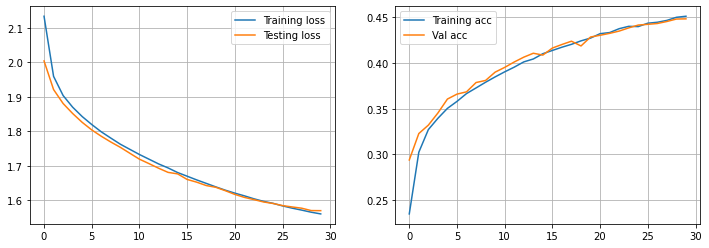

In [38]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Val acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [39]:
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 1.5699390172958374
Test accuracy: 0.44850000739097595


### Hyperparameter search using sklearn

In [69]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

In [79]:
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [128]
epochs = [30]
n_neurons = [128, 256]
param_grid = dict(batch_size=batch_size, 
                  epochs=epochs, 
                  n_neurons=n_neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.464300 using {'batch_size': 128, 'epochs': 30, 'n_neurons': 256}
0.441940 (0.018015) with: {'batch_size': 128, 'epochs': 30, 'n_neurons': 128}
0.464300 (0.005958) with: {'batch_size': 128, 'epochs': 30, 'n_neurons': 256}
